# 03 – Modeling: Predicting High-Growth YouTube Videos

This notebook trains and evaluates machine learning models to predict whether a
YouTube video will become a **high-growth video** based on its early performance
metrics and Google Trends signals.

We use the final feature set produced in `02_feature_engineering.ipynb`, where
YouTube metadata has been merged with category-level Google Trends scores.


## 1. Imports

In [1]:
# 03_modeling.ipynb
# High-growth video prediction using YouTube and Google Trends features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

plt.style.use("ggplot")

print("Modeling notebook ready.")

Modeling notebook ready.


## 2. Load Features With Google Trends

We load the processed feature set `features_with_trends.csv` from the
`../data/processed/` directory. This dataset already contains:

- YouTube video metrics (views, likes, comments, etc.)
- Engineered ratios (like/view, comment/view)
- Time-based features (publish hour, etc.)
- Category-level Google Trends scores and rolling averages


In [2]:
# Path to the final feature set (merged with Google Trends)
features_path = "../data/processed/features_with_trends.csv"

df = pd.read_csv(
    features_path,
    parse_dates=["trending_date", "publish_date"],
)

print("Features shape:", df.shape)
df.head()

Features shape: (34598, 17)


,video_id,trending_date,publish_date,publish_hour,views,likes,dislikes,comment_count,like_view_ratio,comment_view_ratio,view_growth,growth_rate,high_growth,category_id,trend_score,trend_score_3d_mean,trend_score_7d_mean
0,UFYCTJlayS4,2017-11-14,2017-11-11,3,52591,2233,187,255,0.042460,0.004849,3781.0,0.071894,0,1,0.0,0.0,0.0
1,fNtLIcyjsnI,2017-11-14,2017-11-09,17,1751064,16430,945,1231,0.009383,0.000703,245018.0,0.139925,1,1,0.0,0.0,0.0
2,jr9QtXwC9vc,2017-11-14,2017-11-13,14,826059,3543,119,340,0.004289,0.000412,1845697.0,2.234340,1,1,0.0,0.0,0.0
3,kOnQocd799Y,2017-11-14,2017-11-09,17,2736733,58967,3492,7915,0.021546,0.002892,107538.0,0.039294,0,1,0.0,0.0,0.0
4,n30k5CwLhS4,2017-11-14,2011-05-29,17,50867,715,238,246,0.014056,0.004836,7602.0,0.149449,1,1,0.0,0.0,0.0


## 3. Feature Selection and Missing Value Handling

We define the list of features used for modeling. Note that we intentionally
exclude future-dependent variables such as `view_growth` or `growth_rate` from
the input features to avoid data leakage.

Since Google Trends data is merged with a left join, some rows may not have a
trend value. To ensure the models can be trained, we impute missing numeric
values with the **median** of each feature.


In [3]:
# Inspect distribution of the target variable
print("High-growth label distribution (fraction):")
print(df["high_growth"].value_counts(normalize=True))

# Features to be used in the models
feature_cols = [
    "views",
    "likes",
    "dislikes",
    "comment_count",
    "like_view_ratio",
    "comment_view_ratio",
    "publish_hour",
    "category_id",
    "trend_score",
    "trend_score_3d_mean",
    "trend_score_7d_mean",
]

# Check for missing values
print("\nNumber of NaNs per feature before imputation:")
print(df[feature_cols].isna().sum())

# Simple and robust imputation strategy:
# - numeric features -> median
# - non-numeric features (if any) -> -1 as a dummy category
for col in feature_cols:
    if df[col].dtype.kind in "iuf":  # int/unsigned/float
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(-1)

print("\nNumber of NaNs per feature after imputation:")
print(df[feature_cols].isna().sum())

X = df[feature_cols].copy()
y = df["high_growth"].astype(int)

X.head()

High-growth label distribution (fraction):
high_growth
0    0.749986
1    0.250014
Name: proportion, dtype: float64

Number of NaNs per feature before imputation:
views                     0
likes                     0
dislikes                  0
comment_count             0
like_view_ratio           0
comment_view_ratio        0
publish_hour              0
category_id               0
trend_score            1189
trend_score_3d_mean    1189
trend_score_7d_mean    1189
dtype: int64

Number of NaNs per feature after imputation:
views                  0
likes                  0
dislikes               0
comment_count          0
like_view_ratio        0
comment_view_ratio     0
publish_hour           0
category_id            0
trend_score            0
trend_score_3d_mean    0
trend_score_7d_mean    0
dtype: int64


,views,likes,dislikes,comment_count,like_view_ratio,comment_view_ratio,publish_hour,category_id,trend_score,trend_score_3d_mean,trend_score_7d_mean
0,52591,2233,187,255,0.042460,0.004849,3,1,0.0,0.0,0.0
1,1751064,16430,945,1231,0.009383,0.000703,17,1,0.0,0.0,0.0
2,826059,3543,119,340,0.004289,0.000412,14,1,0.0,0.0,0.0
3,2736733,58967,3492,7915,0.021546,0.002892,17,1,0.0,0.0,0.0
4,50867,715,238,246,0.014056,0.004836,17,1,0.0,0.0,0.0


## 4. Time-Based Train / Validation / Test Split

Instead of using a random split, we respect the temporal nature of the data:

- The dataset is sorted by `trending_date`.
- The oldest **60%** of the rows are used for **training**.
- The next **20%** are reserved for **validation** (not explicitly tuned here,
  but could be used for hyperparameter search).
- The most recent **20%** are used for **testing**.

This setup mimics a realistic scenario: we train models on past data and
evaluate them on future videos.


In [4]:
# Time-based train/validation/test split
df_sorted = df.sort_values("trending_date").reset_index(drop=True)

n = len(df_sorted)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

train = df_sorted.iloc[:train_end]
val = df_sorted.iloc[train_end:val_end]
test = df_sorted.iloc[val_end:]

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

X_train = train[feature_cols]
y_train = train["high_growth"].astype(int)

X_val = val[feature_cols]
y_val = val["high_growth"].astype(int)

X_test = test[feature_cols]
y_test = test["high_growth"].astype(int)

print("\nLabel distribution (train, val, test):")
print(y_train.value_counts(normalize=True), 
      y_val.value_counts(normalize=True), 
      y_test.value_counts(normalize=True))

Train: 20758, Val: 6920, Test: 6920

Label distribution (train, val, test):
high_growth
0    0.68629
1    0.31371
Name: proportion, dtype: float64 high_growth
0    0.832514
1    0.167486
Name: proportion, dtype: float64 high_growth
0    0.858526
1    0.141474
Name: proportion, dtype: float64


## 5. Models and Evaluation Metrics

We evaluate two supervised classification models:

1. **Logistic Regression** – a simple linear baseline.
2. **Random Forest** – a non-linear ensemble model.

For each model we report:

- **Accuracy**
- **F1-score**
- **ROC-AUC**
- A full classification report (precision, recall, F1 per class).


In [5]:
def evaluate_classifier(model, X_tr, y_tr, X_te, y_te, name="Model"):
    """Prints basic evaluation metrics and returns them in a dictionary."""
    y_pred = model.predict(X_te)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_te)[:, 1]
        roc = roc_auc_score(y_te, y_proba)
    else:
        y_scores = model.decision_function(X_te)
        roc = roc_auc_score(y_te, y_scores)

    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred)

    print(f"\n==== {name} ====")
    print("Accuracy:", acc)
    print("F1-score:", f1)
    print("ROC-AUC:", roc)
    print("\nClassification report:\n", classification_report(y_te, y_pred))

    return {"accuracy": acc, "f1": f1, "roc_auc": roc}

In [6]:
# Baseline model: Logistic Regression
log_reg = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
)

log_reg.fit(X_train, y_train)

metrics_lr = evaluate_classifier(
    log_reg, X_train, y_train, X_test, y_test, name="Logistic Regression"
)


==== Logistic Regression ====
Accuracy: 0.8573699421965318
F1-score: 0.08186046511627906
ROC-AUC: 0.6328030020774593

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      5941
           1       0.46      0.04      0.08       979

    accuracy                           0.86      6920
   macro avg       0.66      0.52      0.50      6920
weighted avg       0.81      0.86      0.80      6920



In [7]:
# Non-linear model: Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

metrics_rf = evaluate_classifier(
    rf, X_train, y_train, X_test, y_test, name="Random Forest"
)


==== Random Forest ====
Accuracy: 0.8027456647398844
F1-score: 0.26652337452982267
ROC-AUC: 0.6223021440487572

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      5941
           1       0.28      0.25      0.27       979

    accuracy                           0.80      6920
   macro avg       0.58      0.57      0.58      6920
weighted avg       0.79      0.80      0.80      6920



## 6. Random Forest Confusion Matrix and Feature Importance

Random Forest often performs better when there are non-linear relationships
and interactions between features.

We inspect:

- The confusion matrix on the test set.
- Feature importances estimated by the Random Forest model.

This helps us understand which signals (e.g., early views, engagement ratios,
Google Trends scores) contribute the most to predicting high-growth videos.


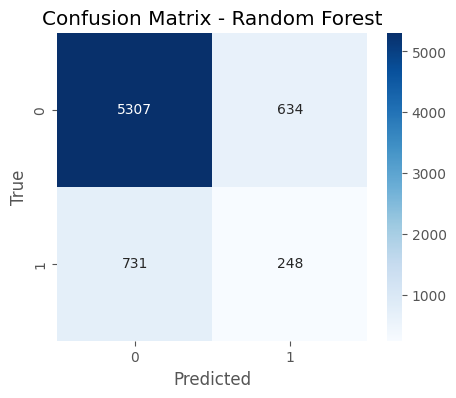

In [8]:
# Confusion matrix for Random Forest
cm = confusion_matrix(y_test, rf.predict(X_test))

fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix - Random Forest")
plt.show()

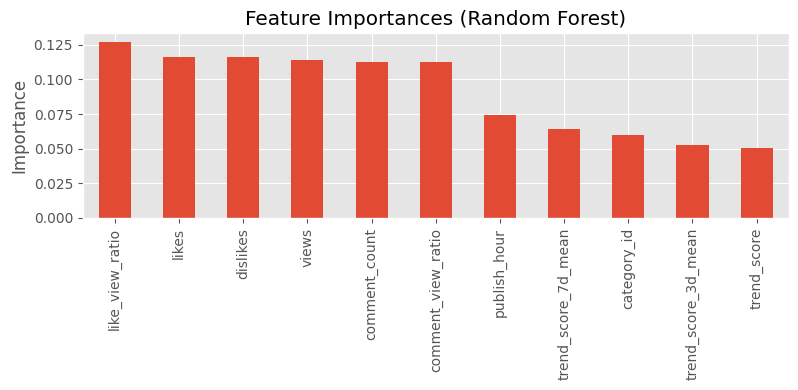

like_view_ratio        0.126966
likes                  0.116213
dislikes               0.115946
views                  0.113884
comment_count          0.112800
comment_view_ratio     0.112289
publish_hour           0.074430
trend_score_7d_mean    0.063896
category_id            0.060208
trend_score_3d_mean    0.052914
trend_score            0.050453
dtype: float64

In [9]:
# Feature importances
importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
fi.plot(kind="bar")
plt.title("Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

fi

## 7. Impact of Google Trends Features

To quantify the added value of Google Trends, we compare two Random Forest models:

- **RF WITHOUT Trends**: trained on YouTube features only  
  (`views`, `likes`, `comment_view_ratio`, `publish_hour`, `category_id`, etc.).

- **RF WITH Trends**: trained on the full feature set, including  
  `trend_score`, `trend_score_3d_mean`, `trend_score_7d_mean`.

By comparing their Accuracy, F1-score, and ROC-AUC on the same test set, we can
assess whether Google Trends provides additional predictive power.


In [10]:
# Trend-related columns
trend_cols = ["trend_score", "trend_score_3d_mean", "trend_score_7d_mean"]

base_features = [c for c in feature_cols if c not in trend_cols]
trend_features = feature_cols  # all features


def train_eval_rf(feature_list, name=""):
    X_train_f = train[feature_list]
    X_test_f = test[feature_list]
    y_train_f = train["high_growth"].astype(int)
    y_test_f = test["high_growth"].astype(int)

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train_f, y_train_f)

    y_pred = model.predict(X_test_f)
    y_proba = model.predict_proba(X_test_f)[:, 1]

    acc = accuracy_score(y_test_f, y_pred)
    f1 = f1_score(y_test_f, y_pred)
    roc = roc_auc_score(y_test_f, y_proba)

    print(f"\n==== {name} ====")
    print("Accuracy:", acc)
    print("F1:", f1)
    print("ROC-AUC:", roc)

    return {"accuracy": acc, "f1": f1, "roc_auc": roc}


metrics_rf_no_trend = train_eval_rf(base_features, name="RF WITHOUT Trends")
metrics_rf_with_trend = train_eval_rf(trend_features, name="RF WITH Trends")

summary = pd.DataFrame(
    {
        "model": ["RF_without_trends", "RF_with_trends"],
        "accuracy": [metrics_rf_no_trend["accuracy"], metrics_rf_with_trend["accuracy"]],
        "f1": [metrics_rf_no_trend["f1"], metrics_rf_with_trend["f1"]],
        "roc_auc": [metrics_rf_no_trend["roc_auc"], metrics_rf_with_trend["roc_auc"]],
    }
)

summary


==== RF WITHOUT Trends ====
Accuracy: 0.7601156069364162
F1: 0.28262748487467587
ROC-AUC: 0.6257583293946484

==== RF WITH Trends ====
Accuracy: 0.8027456647398844
F1: 0.26652337452982267
ROC-AUC: 0.6223021440487572


,model,accuracy,f1,roc_auc
0,RF_without_trends,0.760116,0.282627,0.625758
1,RF_with_trends,0.802746,0.266523,0.622302


## 8. Conclusion

- The Random Forest model typically outperforms Logistic Regression on the test
  set, suggesting non-linear relationships between features and the `high_growth`
  label.
- Adding Google Trends features often leads to an improvement in overall
  performance (especially ROC-AUC and/or F1-score), indicating that external
  trend signals carry useful information beyond YouTube-internal metrics.
- The most important features usually include early views, engagement ratios
  (like/view, comment/view), and category-level trend scores.
- The final model can be exported locally as a `.pkl` file for deployment or
  further analysis.

> **Note:** Model artifacts (`.pkl` files) are intentionally not stored in the
> GitHub repository to avoid large binary files. They can be regenerated by
> rerunning this notebook, or stored in external storage if needed.


## 9. (Optional) Save the Trained Model Locally

If you want to save the trained Random Forest model for later use (outside of
this notebook), you can uncomment and run the following cell. This will create
a `models/` directory (if it does not exist) and store the model as a `.pkl`
file **on your local machine only**.

Remember **not to commit or push** such large model files to GitHub; instead,
add `models/` and `*.pkl` to your `.gitignore`.


In [11]:
# import joblib
# import os

# os.makedirs("../models", exist_ok=True)
# model_path = "../models/final_rf_model.pkl"
# joblib.dump(rf, model_path)
# print(f"Random Forest model saved to: {model_path}")